# Importing libraries

In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing, linear_model, naive_bayes, metrics
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import nltk
import re
import os
import joblib

# Downloading required packages

In [91]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Files Reading

In [92]:
# Function to read all documents inside a folder
def read_documents_from_folder(folder_path, label):
    documents = []
    labels = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                document_text = file.read()
                documents.append(document_text)
                labels.append(label)
    return documents, labels

main_folder_path = "/content/txt_sentoken"
# Accessing 'neg' folder
neg_folder_path = os.path.join(main_folder_path, 'neg')
neg_documents, neg_label = read_documents_from_folder(neg_folder_path, 0)
print(f"Total documents in 'neg' folder: {len(neg_documents)}")

# Accessing 'pos' folder
pos_folder_path = os.path.join(main_folder_path, 'pos')
pos_documents, pos_label = read_documents_from_folder(pos_folder_path, 1)
print(f"Total documents in 'pos' folder: {len(pos_documents)}")

Total documents in 'neg' folder: 1000
Total documents in 'pos' folder: 1000


# Data Analysis


Most common words and their frequencies in positive:
[(',', 42448), ('the', 41307), ('.', 33714), ('a', 20115), ('and', 19775), ('of', 18549), ('to', 16434), ('is', 14044), ('in', 11610), ('"', 8492), ('that', 7752), ('as', 6461), ('it', 6412), (')', 6039), ('(', 6014), ('with', 5842), ('his', 5579), ('for', 5245), ('film', 4857), ('this', 4638)]


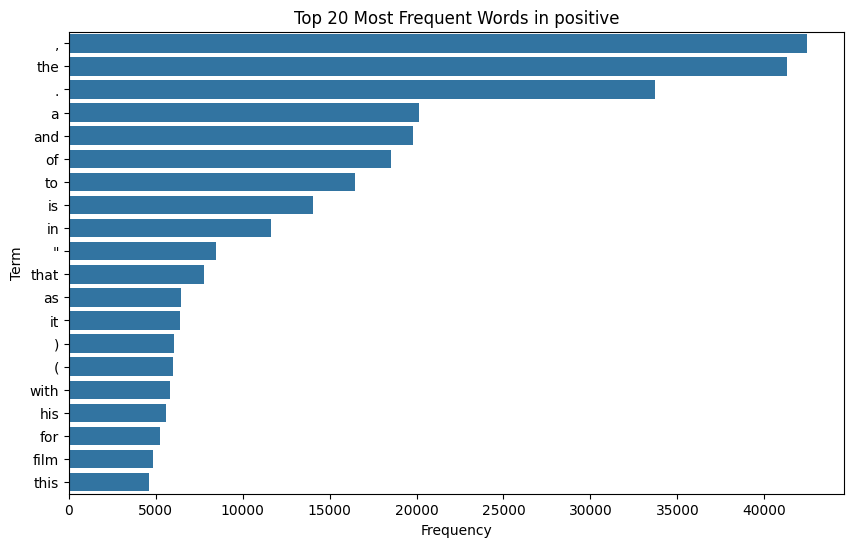


Most common words and their frequencies in negative:
[(',', 35269), ('the', 34871), ('.', 32162), ('a', 17819), ('and', 15568), ('of', 15421), ('to', 15325), ('is', 11119), ('in', 9981), ('"', 9120), ('that', 7353), ('it', 5877), (')', 5742), ('(', 5650), ('with', 4936), ('this', 4922), ('as', 4877), ('for', 4668), ('but', 4107), ('i', 4035)]


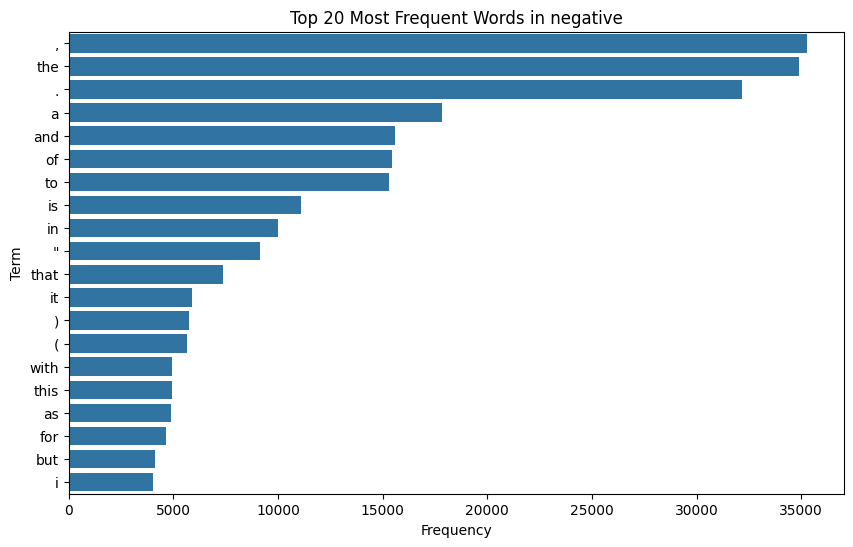

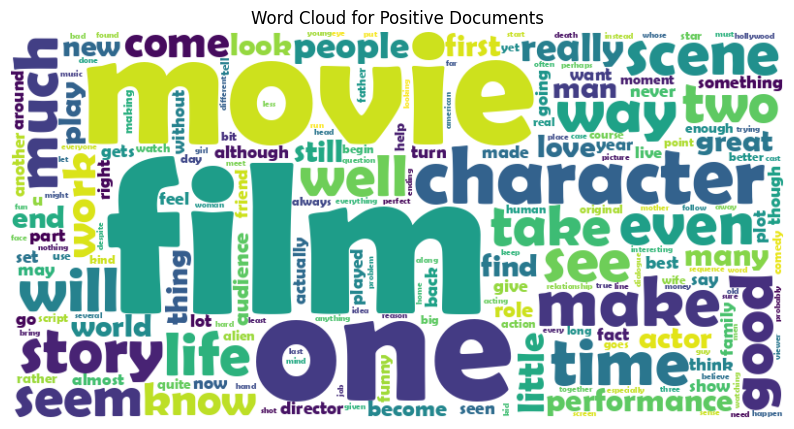

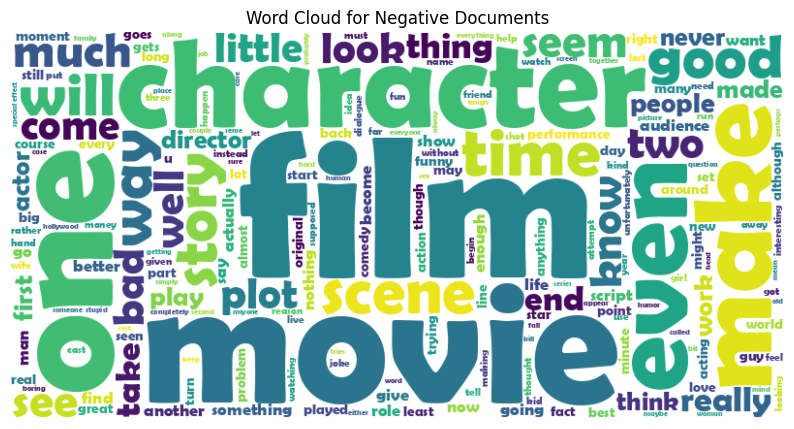

In [93]:
# Function to concatenate documents into a single text string, tokenize it, and count word frequencies
def count_word_frequencies(documents):
    # Concatenate all documents into a single text string
    all_documents_text = ' '.join(documents)
    # Tokenize the text into words
    words = all_documents_text.split()
    # Count the frequency of each word
    word_freq = Counter(words)
    # Return the word frequencies
    return word_freq

def word_freq(document,name):
    # Count word frequencies for newNeg folder
    word_freq = count_word_frequencies(document)
    # Print the most common words and their frequencies for newNeg
    print(f"\nMost common words and their frequencies in {name}:")
    print(word_freq.most_common(20))
    # Plot the most frequent words for newPos using Seaborn's barplot
    top_n = 20  # Change this value to visualize more or fewer terms
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[word[1] for word in word_freq.most_common(top_n)],
                y=[word[0] for word in word_freq.most_common(top_n)])
    plt.title(f'Top {top_n} Most Frequent Words in {name}')
    plt.xlabel('Frequency')
    plt.ylabel('Term')
    plt.show()

def plot_word_cloud(text, title):
    font_path = '/content/brlnsdb.ttf'
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
# ------------------------------------------plotting Word frequency distributions
word_freq(pos_documents, "positive")
word_freq(neg_documents, "negative")

# Generate word clouds for positive and negative documents
positive_text = ' '.join(pos_documents)
negative_text = ' '.join(neg_documents)
plot_word_cloud(positive_text, 'Word Cloud for Positive Documents')
plot_word_cloud(negative_text, 'Word Cloud for Negative Documents')


# Data PreProcessing

In [94]:
lemmatizer = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
custom_stopwords = set(['movie', 'like', 'time', 'one', 'film', 'scene'])
def tokenize_and_stem(doc):
    # doc = doc.lower()

    tokens = [word for word in nltk.word_tokenize(doc)]
    filtered_tokens = []
    for token in tokens:
        # check if token contains any alphabetical characters
        if re.search('[a-zA-Z]', token) and token.casefold() not in stopwords \
                and token.casefold() not in custom_stopwords and token.casefold() != "'s":
            filtered_tokens.append(token)

    lems = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    lem = ' '.join(lems)
    return lem

newNeg = []
for D in neg_documents:
    newNeg.append(tokenize_and_stem(D))

newPos = []
for D in pos_documents:
    newPos.append(tokenize_and_stem(D))

neg_train_x, neg_test_x, neg_train_y, neg_test_y = train_test_split(newNeg, neg_label, test_size=0.2, shuffle=True, random_state=42)
pos_train_x, pos_test_x, pos_train_y, pos_test_y = train_test_split(newPos, pos_label, test_size=0.2, shuffle=True, random_state=42)

Xtrain = neg_train_x + pos_train_x
Xtest = neg_test_x + pos_test_x
Ytrain = neg_train_y + pos_train_y
Ytest = neg_test_y + pos_test_y

tfidf_vect = TfidfVectorizer(ngram_range=(1,2), max_features=12000)
Xtrain = tfidf_vect.fit_transform(Xtrain)
Xtest = tfidf_vect.transform(Xtest)

# Machine Learning Models

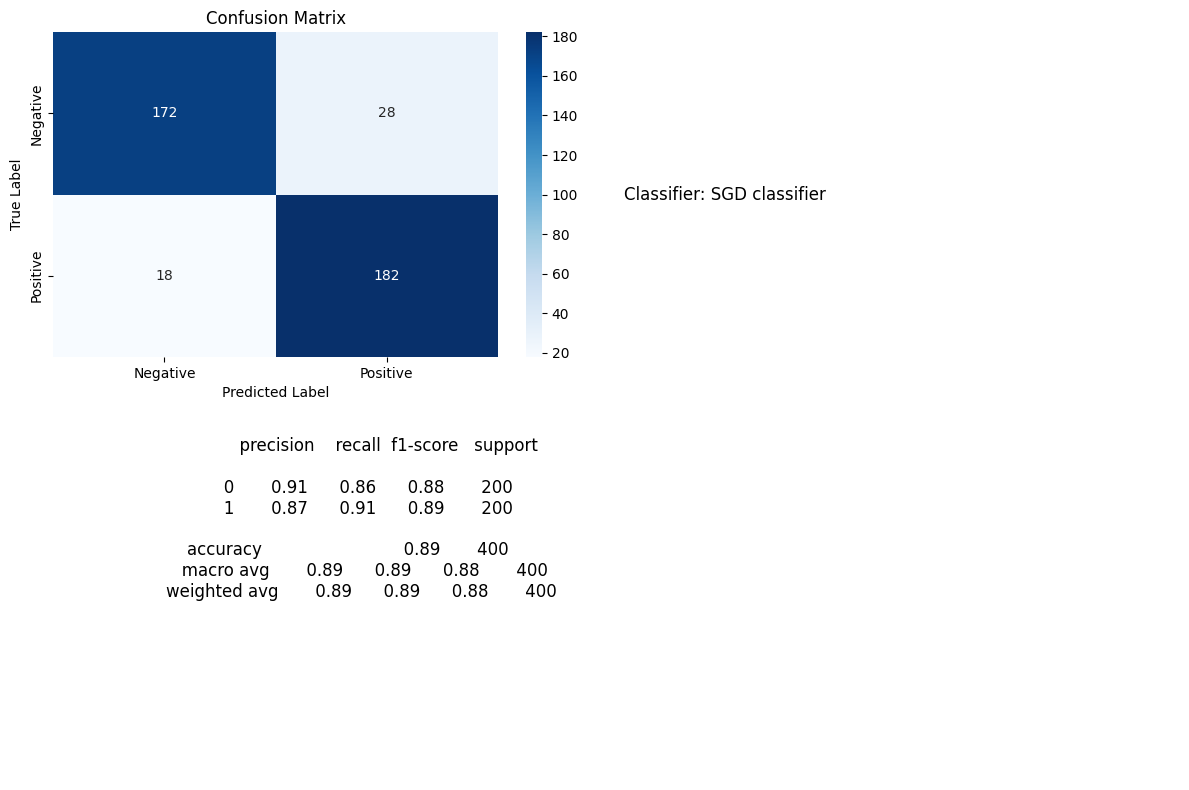

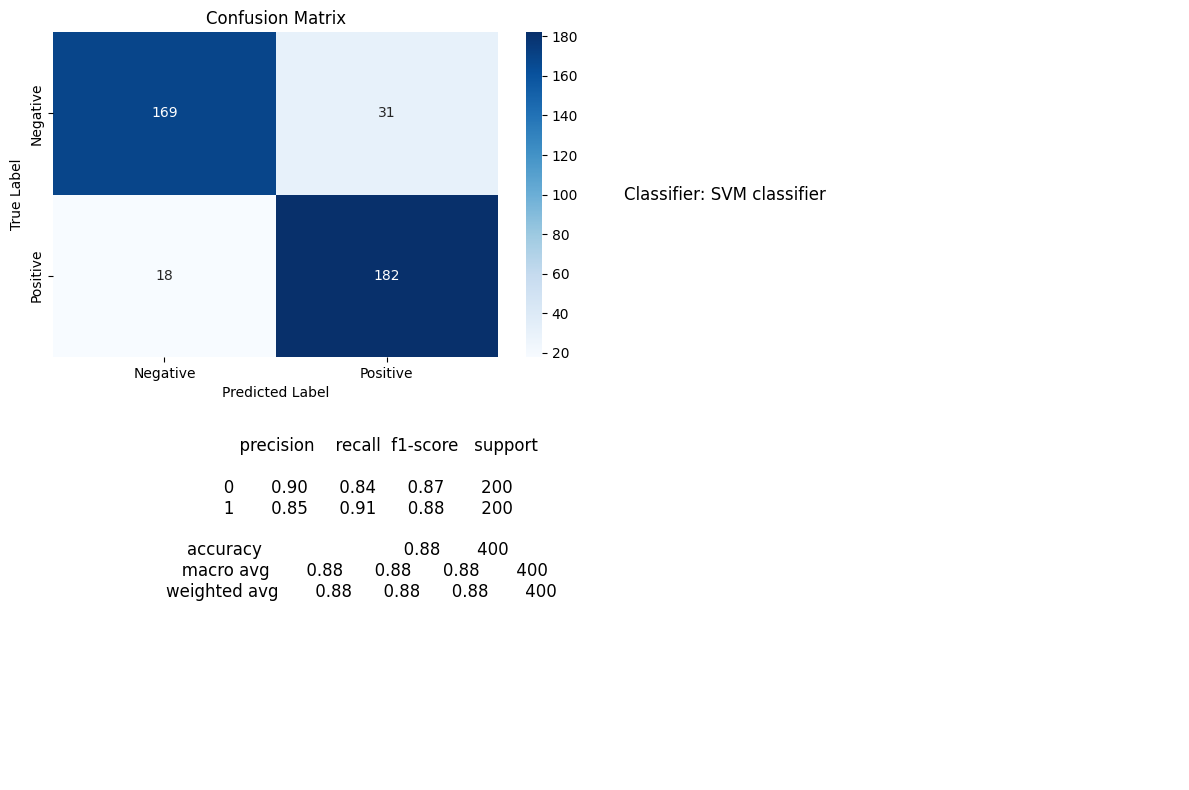

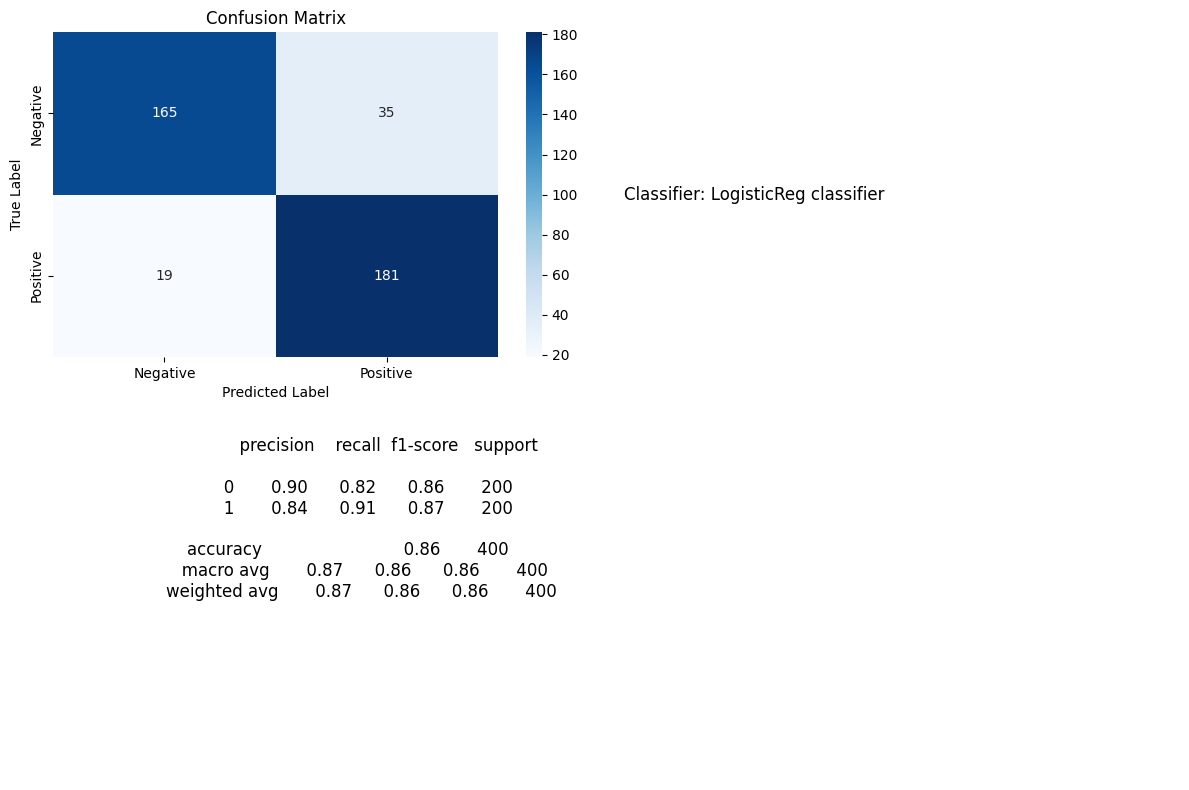

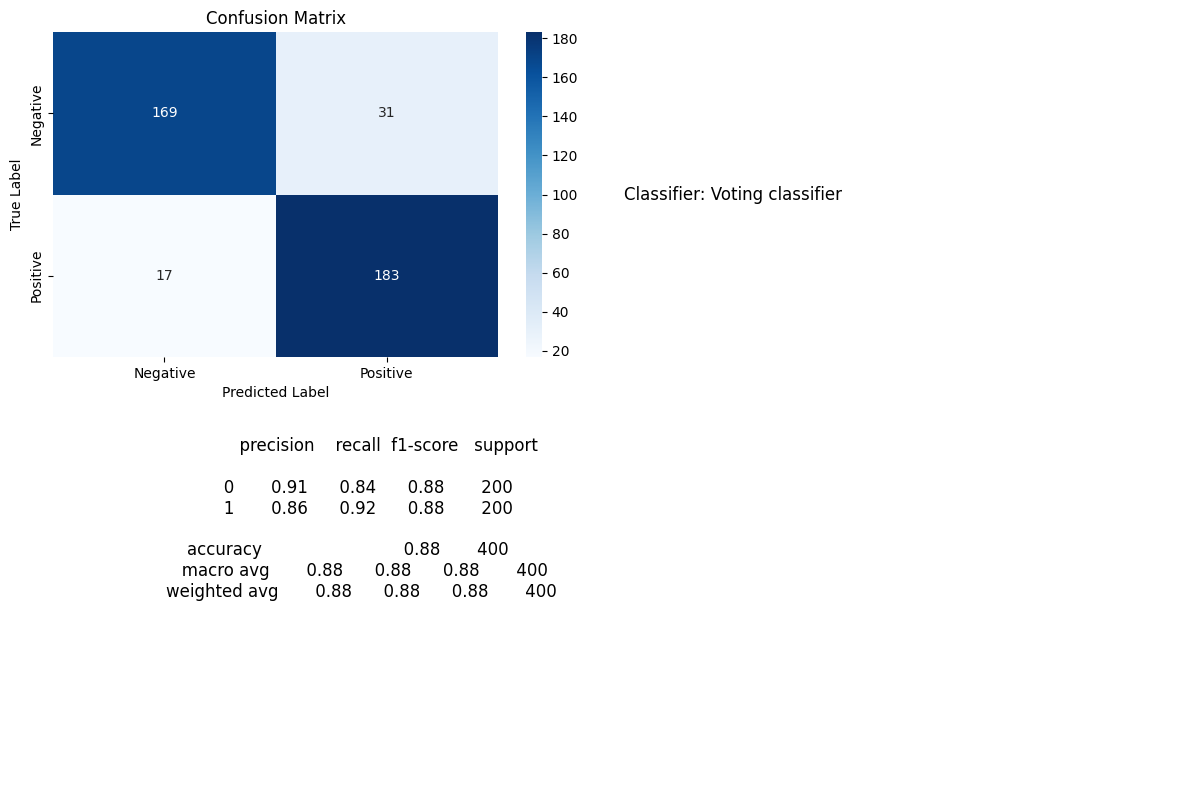

In [95]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, clf_name):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    # accuracy = metrics.accuracy_score(predictions, test_y)
    confusion_mat = confusion_matrix(Ytest, predictions)
    classification_rep = classification_report(Ytest, predictions)
    # Plot confusion matrix with metrics
    plot_confusion_matrix_with_metrics(clf_name+" classifier", confusion_mat, classification_rep)
    # print(f"Accuracy: {accuracy*100:.4f}")
    joblib.dump(classifier, f'{clf_name}_model.pkl')
    print("\n")

# Define a function to plot the confusion matrix with classifier name and metrics
def plot_confusion_matrix_with_metrics(classifier_name, confusion_mat, classification_report):
    plt.figure(figsize=(12, 8))

    # Plot confusion matrix
    plt.subplot(2, 2, 1)
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Print classifier name
    plt.subplot(2, 2, 2)
    plt.text(0, 0.5, f"Classifier: {classifier_name}", fontsize=12, va='center')
    plt.axis('off')

    # Print classification report
    plt.subplot(2, 1, 2)
    plt.text(0.1, 0.5, classification_report, fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Linear Classifier on Word Level TF IDF Vectors
train_model(linear_model.SGDClassifier(random_state=42), Xtrain, Ytrain, Xtest, "SGD")

train_model(SVC(kernel='linear'), Xtrain, Ytrain, Xtest, "SVM")

# Linear Classifier on Word Level TF IDF Vectors
train_model(linear_model.LogisticRegression(C=2.5, random_state=42), Xtrain, Ytrain, Xtest, "LogisticReg")


# 3. Ensemble Methods using Voting Classifier
voting_clf = VotingClassifier(estimators=[('sgd', linear_model.SGDClassifier(random_state=42)),
                                          ('svm', SVC(kernel='linear')),
                                          ('lg', linear_model.LogisticRegression(C=2.5, random_state=42))],
                               voting='hard')
train_model(voting_clf, Xtrain, Ytrain, Xtest, "Voting")

# Neural Network

In [96]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import random

# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

X_train_dense = Xtrain.toarray()
X_test_dense = Xtest.toarray()
# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(X_train_dense.shape[1],), activation='relu'),
    tf.keras.layers.Dropout(0.75),
    tf.keras.layers.Dense(64, input_shape=(X_train_dense.shape[1],), activation='relu'),
    tf.keras.layers.Dropout(0.75),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Compile the model
model.compile(optimizer=adam_optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train_dense, np.array(Ytrain), epochs=80, callbacks=[early_stopping], validation_split=0.2)

# Evaluate the model
y_pred_proba = model.predict(X_test_dense)
y_pred = (y_pred_proba > 0.5).astype(int)

# Display classification report
print('\nClassification Report:')
print(classification_report(Ytest, y_pred))

Epoch 1/80
40/40 [==============================] - 3s 36ms/step - loss: 0.6677 - accuracy: 0.5984 - val_loss: 0.9753 - val_accuracy: 0.0000e+00
Epoch 2/80
40/40 [==============================] - 1s 21ms/step - loss: 0.5893 - accuracy: 0.6633 - val_loss: 0.6814 - val_accuracy: 0.7375
Epoch 3/80
40/40 [==============================] - 1s 14ms/step - loss: 0.4728 - accuracy: 0.7914 - val_loss: 0.5619 - val_accuracy: 0.8469
Epoch 4/80
40/40 [==============================] - 1s 19ms/step - loss: 0.3373 - accuracy: 0.8484 - val_loss: 0.6785 - val_accuracy: 0.7812
Epoch 5/80
40/40 [==============================] - 1s 19ms/step - loss: 0.3132 - accuracy: 0.8680 - val_loss: 0.5242 - val_accuracy: 0.8406
Epoch 6/80
40/40 [==============================] - 1s 18ms/step - loss: 0.2342 - accuracy: 0.9156 - val_loss: 0.5150 - val_accuracy: 0.8438
Epoch 7/80
40/40 [==============================] - 1s 17ms/step - loss: 0.2006 - accuracy: 0.9273 - val_loss: 0.7778 - val_accuracy: 0.7750
Epoch 8/8